# Comparing LISFLOOD calibrations
*** 

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import yaml
from pathlib import Path
import xarray as xr
from tqdm.notebook import tqdm
from datetime import timedelta

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [43]:
from reservoirs import Lisflood
from metrics import KGEmod, ECDF
from calibration.bivariate_lisflood import bivariate_6pars_1of
from plots import create_cmap

In [38]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [39]:
# config plots
proj = ccrs.PlateCarree()
extent = [-125, -67.5, 24, 51]

catchment_pol = gpd.read_file('../GIS/catchments_US.shp')
catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

In [4]:
sns.set_style('ticks')

## Configuration

In [5]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

In [6]:
# results will be saved in this path
path_results = Path('../results/reservoirs/LISFLOOD/calibration/')
paths = {'SCEUA-Q': path_results / 'SCEUA' / '6parameters' / 'univariate' / 'outflow',
         'SCEUA-S': path_results / 'SCEUA' / '6parameters' / 'univariate' / 'storage',
         # 'MC-QS': path_results / 'MC' / '6parameters' / 'bivariate',
         'SCEUA-QS': path_results / 'SCEUA' / '6parameters' / 'bivariate'}

In [7]:
par_space = {'FFf': (0.20, 0.99),
             'alpha': (0.001, 0.999),
             'beta': (0.001, 0.999),
             'QQf': (0.1, 0.99),
             'gamma': (0.001, 0.999),
             'k': (1.0, 5.0)}

In [111]:
path_out = Path('../results/reservoirs/LISFLOOD/calibration/plots/')
path_out.mkdir(parents=True, exist_ok=True)

## Data

### GloFAS

#### Reservoirs

In [8]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../GIS/reservoirs_analysis_US.shp')
reservoirs.set_index('ResID', drop=True, inplace=True)

print(f'{reservoirs.shape[0]} reservoirs in the shape file')

94 reservoirs in the shape file


#### Time series

In [9]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs in the GloFAS time series')

# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

# period of GloFAS simulation
start, end = glofas_ts[id].first_valid_index(), glofas_ts[id].last_valid_index()

  0%|          | 0/143 [00:00<?, ?it/s]

94 reservoirs in the GloFAS time series


### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [10]:
# load GRanD data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# extract reservoirs of interes
grand = grand.loc[reservoirs.GRAND_ID]

In [11]:
# define single-use reservoirs
grand['SINGLE_USE'] = (~grand[[col for col in grand.columns if ('USE' in col) & (col != 'MAIN_USE')]].isnull()).sum(axis=1) == 1

In [12]:

reservoirs['MAIN_USE'] = grand.loc[reservoirs.GRAND_ID, 'MAIN_USE'].values
reservoirs['SINGLE_USE'] = grand.loc[reservoirs.GRAND_ID, 'SINGLE_USE'].values

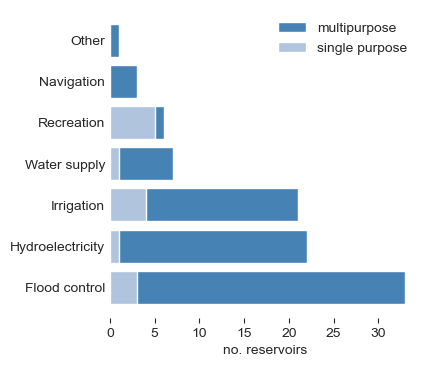

In [112]:
use_summary_singlepurpose = reservoirs.loc[reservoirs.SINGLE_USE, 'MAIN_USE'].value_counts()
use_summary_multipurpose = reservoirs['MAIN_USE'].value_counts()

fig, ax = plt.subplots(figsize=(4, 4))
ax.barh(use_summary_multipurpose.index, use_summary_multipurpose.values, color='steelblue', label='multipurpose')
ax.barh(use_summary_singlepurpose.index, use_summary_singlepurpose.values, color='lightsteelblue', label='single purpose')
ax.set(#title='Reservoir main use',
       xlabel='no. reservoirs')
ax.tick_params(axis='y', length=0)
ax.legend(loc=1, frameon=False)
ax.spines[['top', 'left', 'right', 'bottom']].set_visible(False);

plt.savefig(path_out / 'reservoir_main_use.jpg', dpi=300, bbox_inches='tight');

ValueError: 'color' kwarg must be a color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

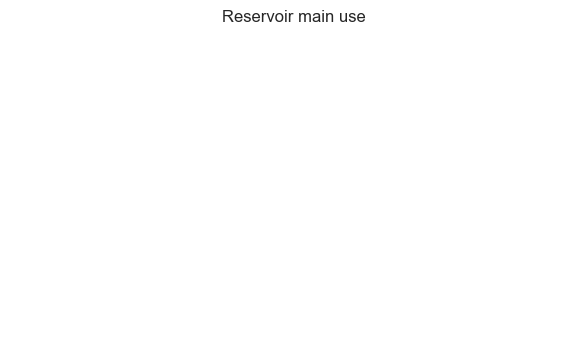

In [109]:
# fig, ax = plt.subplots(figsize=(7.5, 3.5), tight_layout=True, subplot_kw={'projection': proj})

# # background map
# catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
# ax.set(extent=extent)
# ax.axis('off')
# ax.set_title('Reservoir main use')

# # scatter plot
# sct = ax.scatter(reservoirs.geometry.x,
#                  reservoirs.geometry.y,
#                  color=reservoirs.MAIN_USE,
#                  cmap='Spectral', edgecolor='w', lw=1, 
#                   s=reservoirs.CAP**.5, alpha=.8)

### ResOpsUS
#### Time series

In [14]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

print(f'{len(resops_ts)} reservoirs in the ResOpsUS time series')
    
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/94 [00:00<?, ?it/s]

94 reservoirs in the ResOpsUS time series


## Performance

In [15]:
train_size = .7

parameters = {sampling: pd.DataFrame(dtype=float) for sampling in ['GloFAS'] + list(paths)}

metrics = ['KGE', 'alpha', 'beta', 'r']
#performance = {var: {sampling: df.copy() for sampling in pars.sampling.data} for var in ['outflow', 'storage']}
performance = {sampling: {var: pd.DataFrame(columns=metrics) for var in ['outflow', 'storage']} for sampling in ['GloFAS'] + list(paths)}

for sampling, path in tqdm(paths.items()):
    files = path.glob('*_samples.csv')
    for file in tqdm(files):
        ResID = int(str(file).split('\\')[-1].split('_')[0])
        
        # read results of the sampling
        try:
            results = pd.read_csv(file)
            parcols = {col: col[3:] for col in results.columns if col.startswith('par')}
            parnames = parcols.values()
            results.rename(columns=parcols, inplace=True)
        except:
            print(f'File {file} could not be opened')

        # find the best iteration and its associated parameters
        try:
            if 'like2' in results.columns:
                best_iter = results[['like1', 'like2']].pow(2).sum(axis=1).pow(.5).idxmin()
            else:
                best_iter = results.like1.idxmin()
            best_pars = results.loc[best_iter, parnames]
            best_pars.name = ResID
            parameters[sampling] = pd.concat((parameters[sampling], best_pars), axis=1)
        except:
            print(f'ERROR. The best parameters of reservoir {ResID} with sampling {sampling} could not be found')
                
        # define observed and simulated inflow time series
        try:
            obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
            obs[obs < 0] = np.nan
            # define calibration period
            if obs.outflow.isnull().all():
                print(f'Reservoir {ResID} is missing outflow records')
                continue
            elif obs.storage.isnull().all():
                print(f'Reservoir {ResID} is missing storage records')
                continue
            else:
                start_obs = max([obs[var].first_valid_index() for var in ['storage', 'outflow']])
                end_obs = min([obs[var].last_valid_index() for var in ['storage', 'outflow']])
                cal_days = timedelta(days=np.floor((end_obs - start_obs).days * train_size))
                start_cal = end_obs - cal_days
            obs = obs.loc[start_cal:end_obs]
            inflow = glofas_ts[ResID].loc[start_cal:end_obs].inflow
        except:
            print(f'Error while defining the time series for reservoir {ResID}')
        
        # define the reservoir parameters
        try:
            FFc, FFn, FFn_adj, FFf, Qc, Qn, Qf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'minq', 'normq_adj', 'ndq', 'CAP']]
            Vtot *= 1e6
            Vc = FFc * Vtot
            # what would be the calibration parameters in the GloFAS run?
            if ResID not in parameters['GloFAS'].columns:
                alpha = (FFn - FFc) / (FFf - FFc)
                beta = (FFn_adj - FFn) / (FFf - FFn)
                QQf = inflow[inflow <= Qf].count() / len(inflow)
                gamma = Qn / Qf
                glofas_pars = pd.Series({'FFf': FFf, 'alpha': alpha, 'beta': beta, 'QQf': QQf, 'gamma': gamma, 'k': 1.2},
                                        name=ResID)
                parameters['GloFAS'] = pd.concat((parameters['GloFAS'], glofas_pars), axis=1)
            # calibrated parameters
            Vf = Vtot * best_pars['FFf']
            Vn = Vc + best_pars['alpha'] * (Vf - Vc)
            Vn_adj = Vn + best_pars['beta'] * (Vf - Vn)
            Qf = inflow.quantile(best_pars['QQf'])
            Qn = best_pars['gamma'] * Qf
            k = best_pars['k']
        except:
            print(f'ERROR while defining the parameters of reservoir {ResID}')
            continue
        
        # declare the reservoir and simulate
        try:
            res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qc, Qn, Qf)
            sim = res.simulate(inflow, obs.loc[start_cal, 'storage'], limit_Q=True, k=k)
        except:
            print(f'Error while simulating reservoir {ResID}')
            
        # performance of the simulation
        try:
            for var, df in performance['GloFAS'].items():
                df.loc[ResID] = KGEmod(obs[var], glofas_ts[ResID].loc[start_cal:end_obs, var])
            for var, df in performance[sampling].items():
                df.loc[ResID] = KGEmod(obs[var], sim[var])
        except:
            print(f'Error while computing performance for reservoir {ResID}')

# convert results to Datasets
parameters = xr.Dataset({sampling: xr.DataArray(df, dims=['parameter', 'ResID']) for sampling, df in parameters.items()})
performance = xr.Dataset({sampling: xr.Dataset({var: xr.DataArray(df, dims=['ResID', 'metric']) for var, df in dct.items()}).to_array(dim='variable') for sampling, dct in performance.items()})

# limit reservoirs to those for which parameters were optimized
ResIDs = list(set(parameters.ResID.data).intersection(performance.ResID.data))
reservoirs = reservoirs.loc[ResIDs]

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

## Analysis
### Performance

In [16]:
# KGE bivariate
KGE_bivar = xr.Dataset({sampling: 1 - ((1 - da.sel(metric='KGE'))**2).sum('variable')**.5 for sampling, da in performance.items()})
KGE_bivar = KGE_bivar.to_pandas().drop('metric', axis=1)

In [22]:
sample_color = {'GloFAS': 'k',
                'SCEUA-Q': 'salmon',
                'SCEUA-S': 'gold',#'khaki',
                'SCEUA-QS': 'steelblue',
                'MC-QS': 'lightsteelblue'}

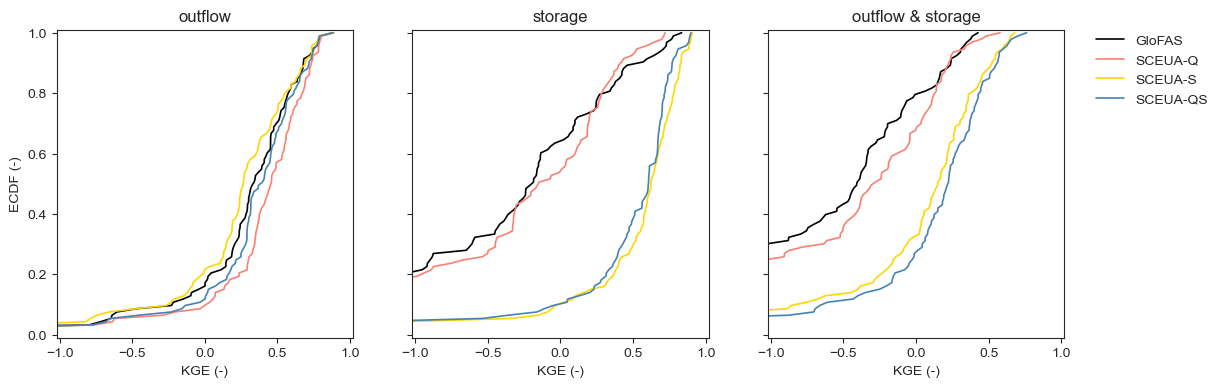

In [114]:
fig, axes = plt.subplots(ncols=3, figsize=(13, 4), sharex=True, sharey=True)
for ax, var in zip(axes, performance.variable.data):
    for sampling, da in performance.items():
        ecdf = ECDF(da.sel(metric='KGE', variable=var).to_pandas(), plot=False)
        ax.plot(ecdf.values, ecdf.index, c=sample_color[sampling], lw=1.2, label=sampling)
    ax.set(#xlim=(-1.02, 1.02),
           #ylim=(-.01, 1.01),
           xlabel='KGE (-)',
           title=var)
    if ax == axes[0]:
        ax.set_ylabel('ECDF (-)')
        
ax = axes[2]
for sampling in KGE_bivar.columns:
    ecdf = ECDF(KGE_bivar[sampling], plot=False)
    ax.plot(ecdf.values, ecdf.index, c=sample_color[sampling], lw=1.2, label=sampling)
ax.set(xlim=(-1.02, 1.02),
       ylim=(-.01, 1.01),
       xlabel='KGE (-)',
       title='outflow & storage')
    
fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .6, .1, .3]);

plt.savefig(path_out / f'ecdf_KGE.jpg', dpi=300, bbox_inches='tight');

Divide the previous by use.

In [26]:
use_color = {'Flood control': 'steelblue', 'Hydroelectricity': 'salmon', 'Irrigation': 'gold'}

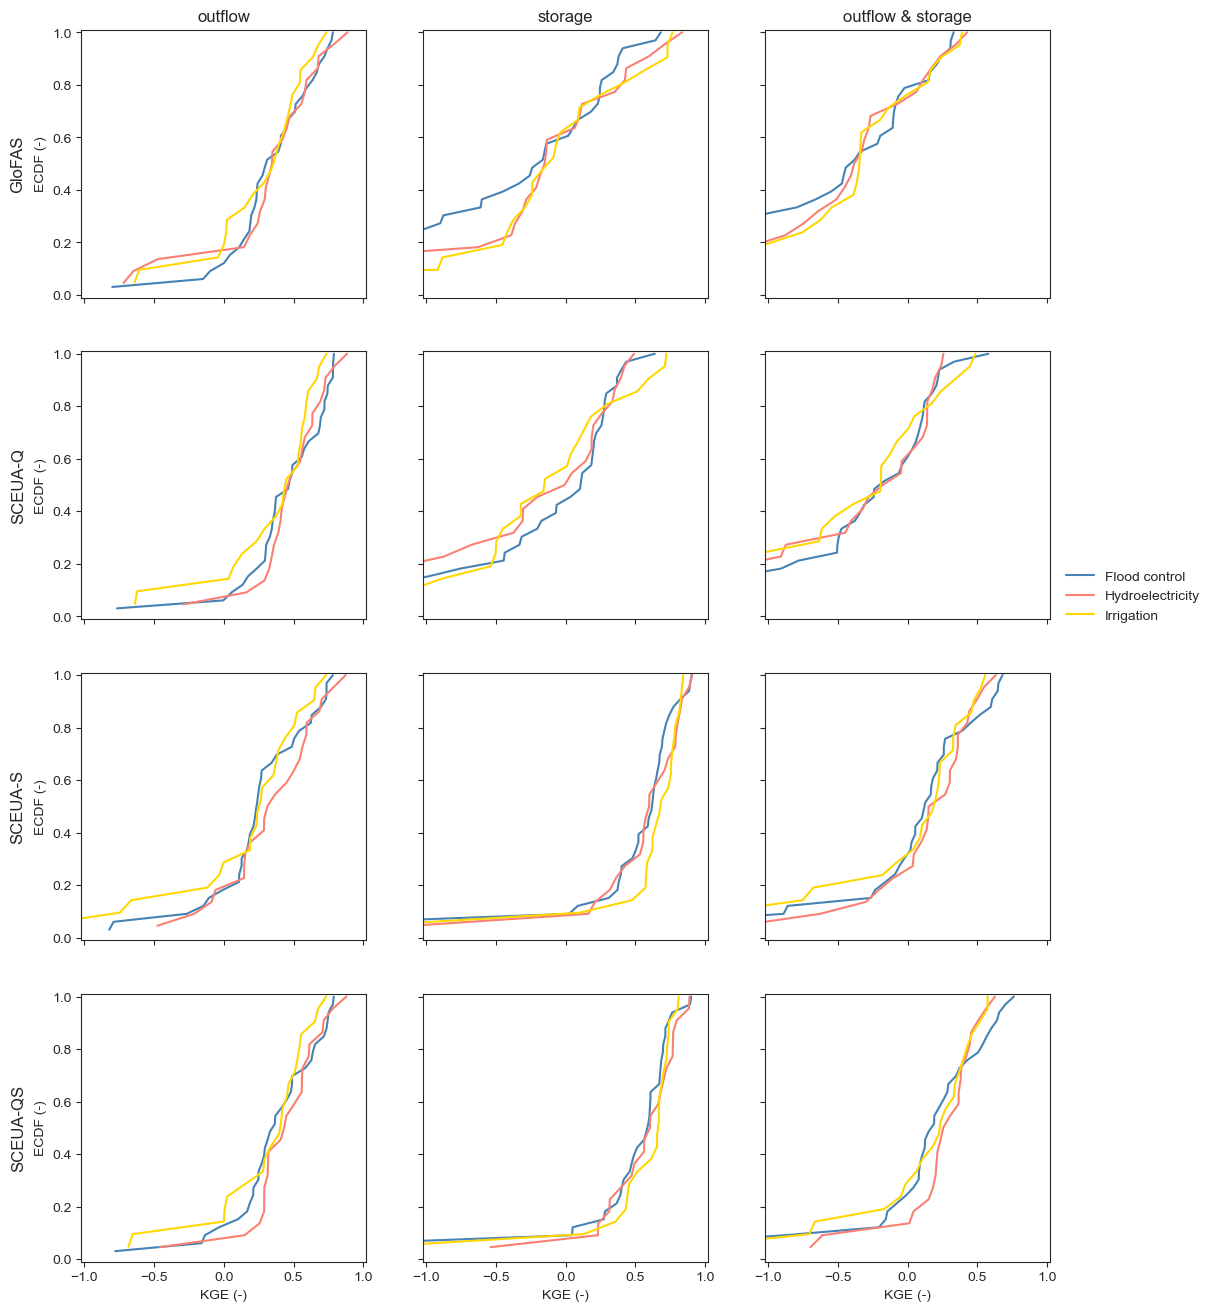

In [28]:
samplings = ['GloFAS', 'SCEUA-Q', 'SCEUA-S', 'SCEUA-QS']

fig, axes = plt.subplots(nrows=len(samplings), ncols=3, figsize=(12.5, 4 * len(samplings)), sharex=True, sharey=True)
for i, sampling in enumerate(samplings):
    da = performance[sampling]
    for j, var in enumerate(performance.variable.data):
        ax = axes[i,j]
        for use in ['Flood control', 'Hydroelectricity', 'Irrigation']:
            ResIDs = reservoirs[reservoirs.MAIN_USE == use].index
            ecdf = ECDF(performance[sampling].sel(metric='KGE', variable=var, ResID=ResIDs).to_pandas(), plot=False)
            ax.plot(ecdf.values, ecdf.index, c=use_color[use], label=use)
        if i == 0:
            ax.set_title(var)
        elif i == len(samplings) - 1:
            ax.set_xlabel('KGE (-)')
        if j == 0:
            ax.set_ylabel('ECDF (-)')
            ax.text(-.25, .5, sampling, fontsize=12, rotation=90, va='center', transform=ax.transAxes)

    ax = axes[i, 2]
    for use in ['Flood control', 'Hydroelectricity', 'Irrigation']:
        ResIDs = reservoirs[reservoirs.MAIN_USE == use].index
        ecdf = ECDF(KGE_bivar.loc[ResIDs, sampling], plot=False)
        ax.plot(ecdf.values, ecdf.index, c=use_color[use], label=use)
    ax.set(xlim=(-1.02, 1.02),
           ylim=(-.01, 1.01))
    if i == 0:
            ax.set_title('outflow & storage')
    elif i == len(samplings) - 1:
        ax.set_xlabel('KGE (-)')
    if j == 0:
        ax.set_ylabel('ECDF (-)')

fig.legend(*ax.get_legend_handles_labels(), frameon=False, bbox_to_anchor=[.92, .45, .11, .1]);

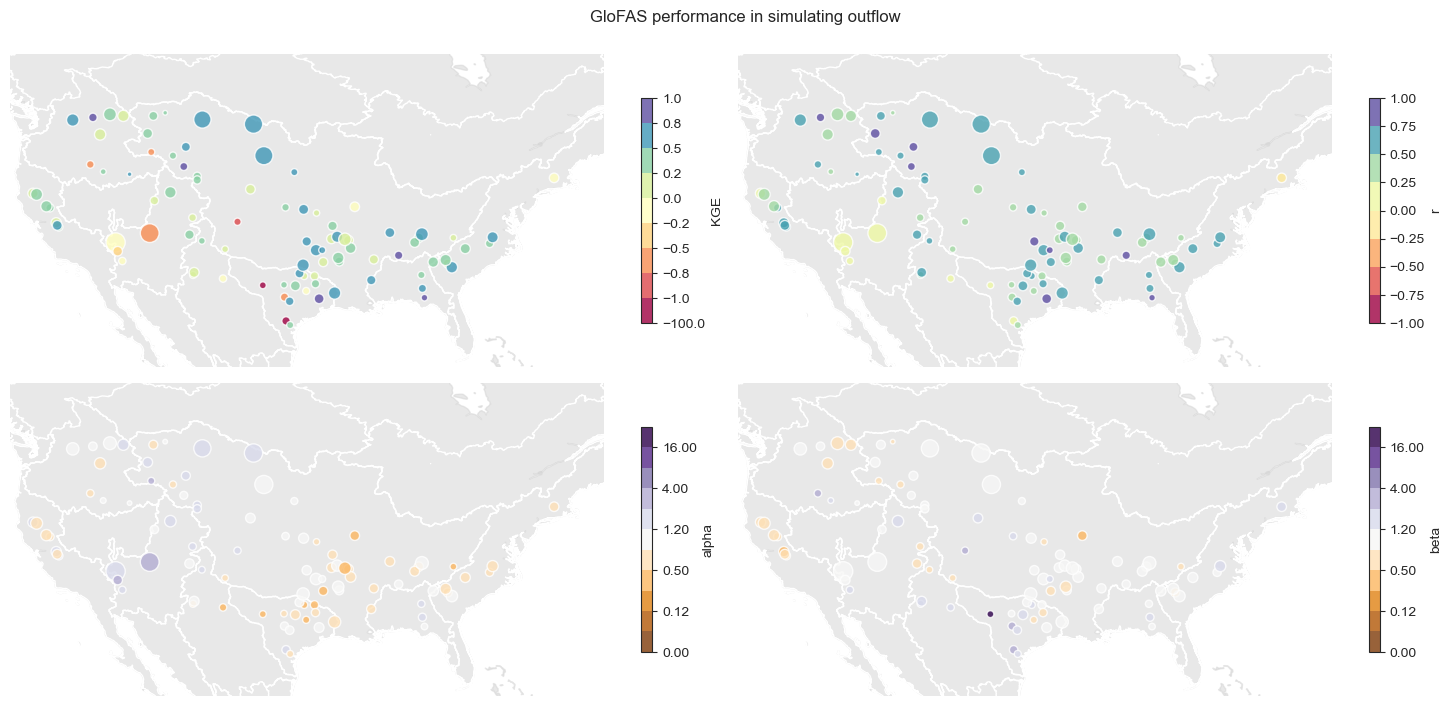

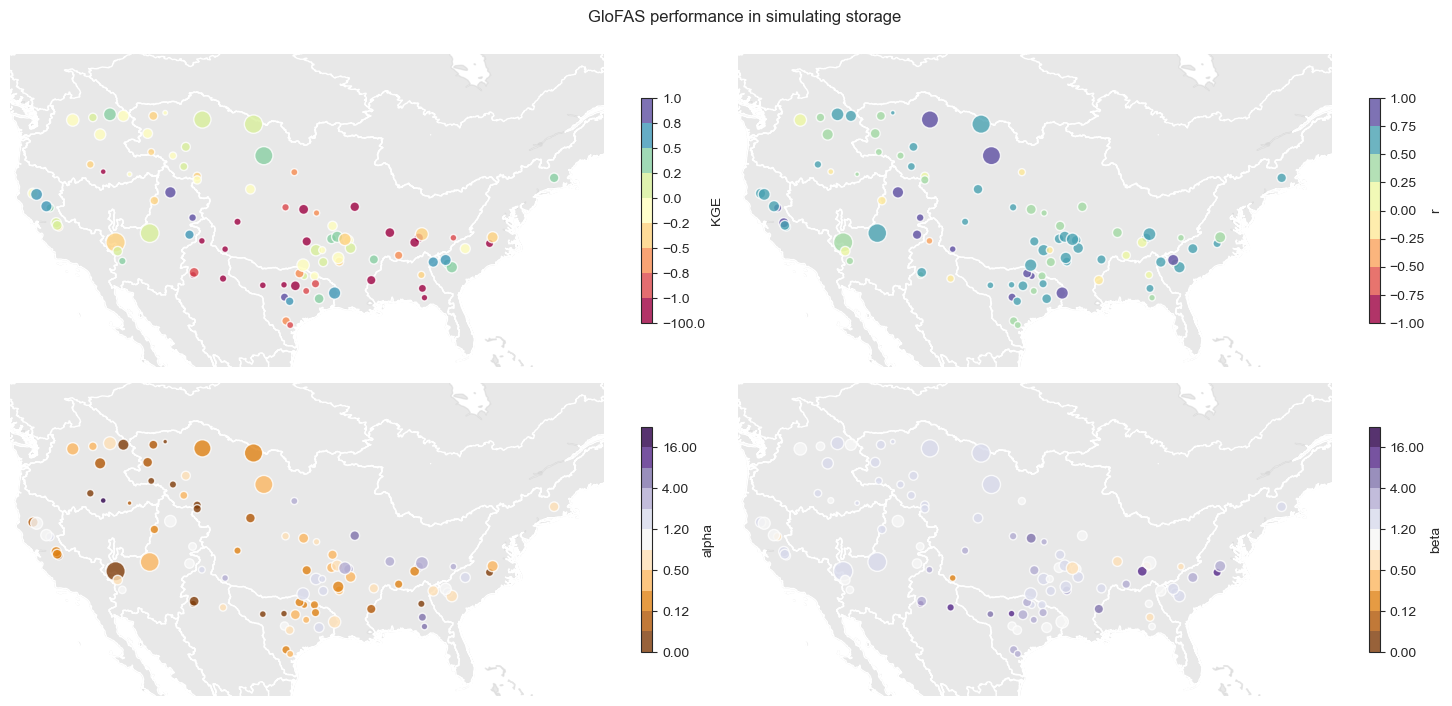

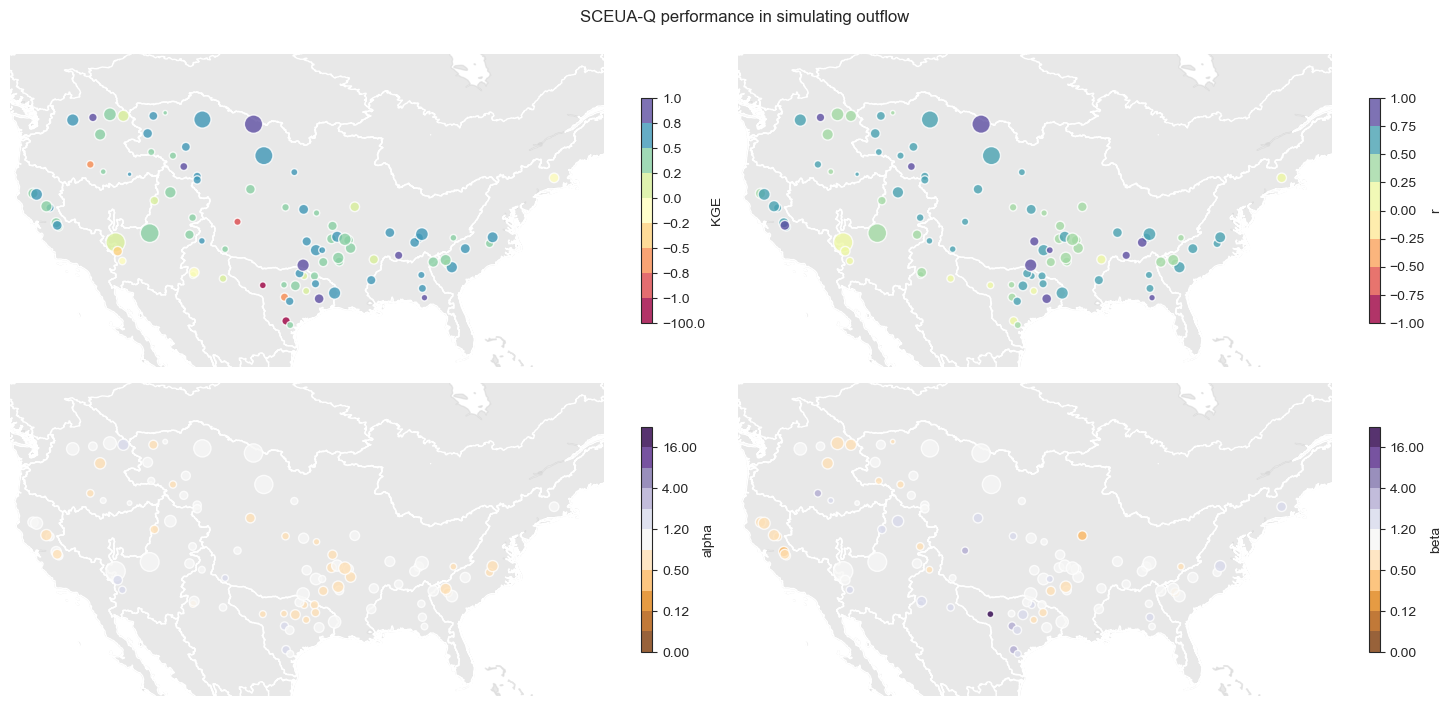

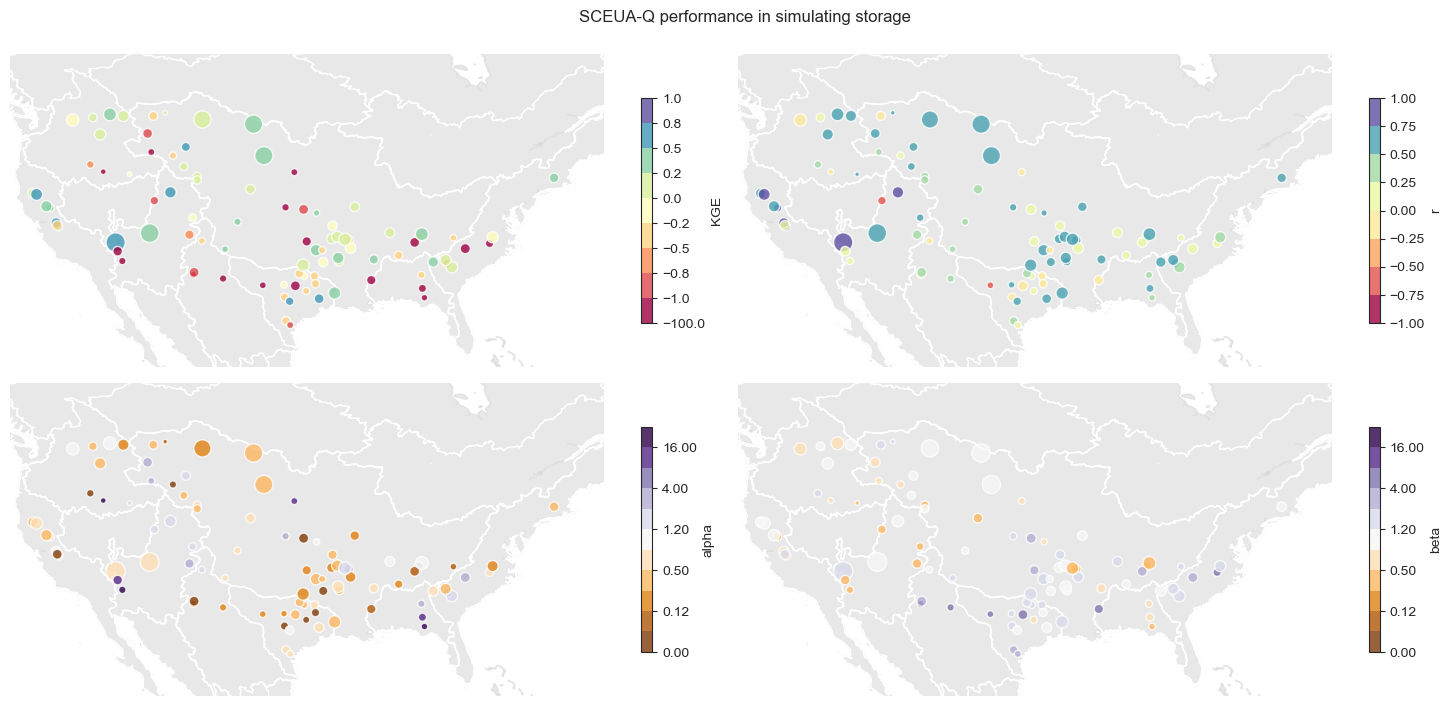

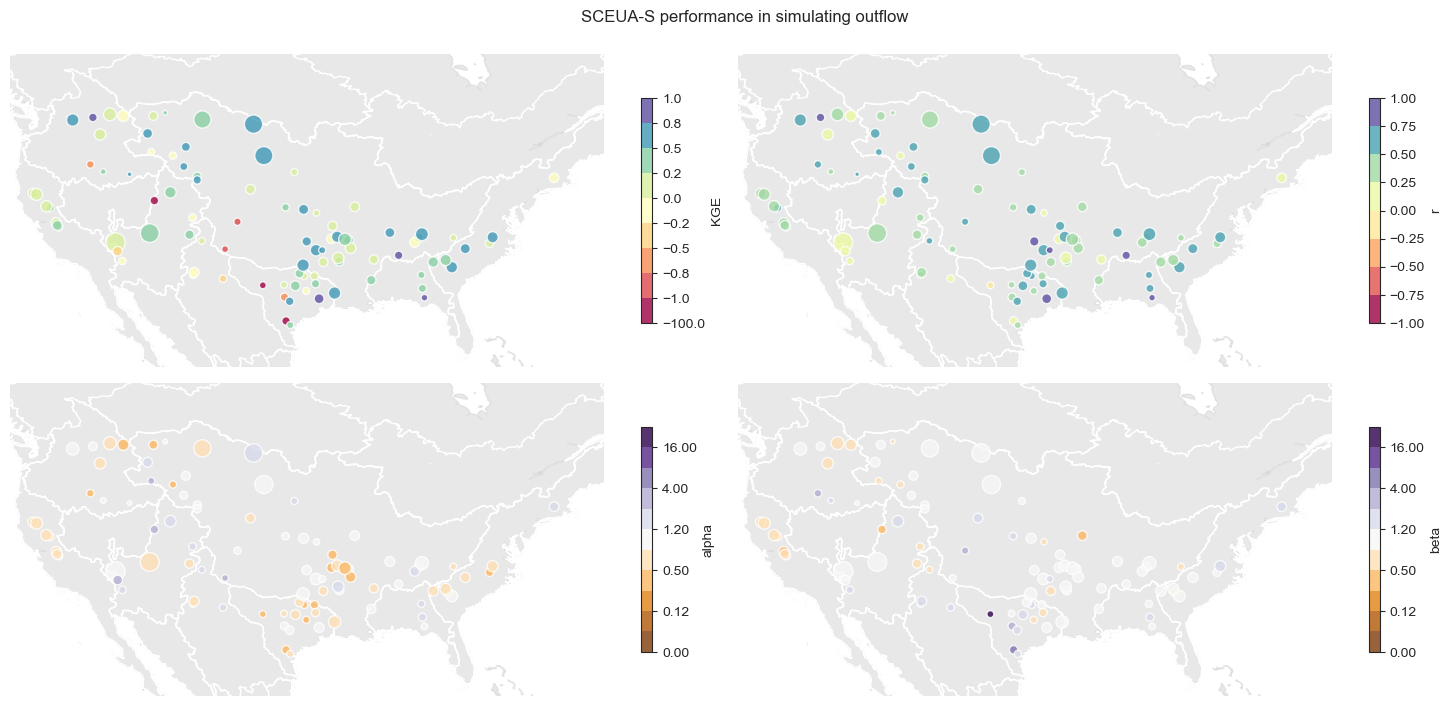

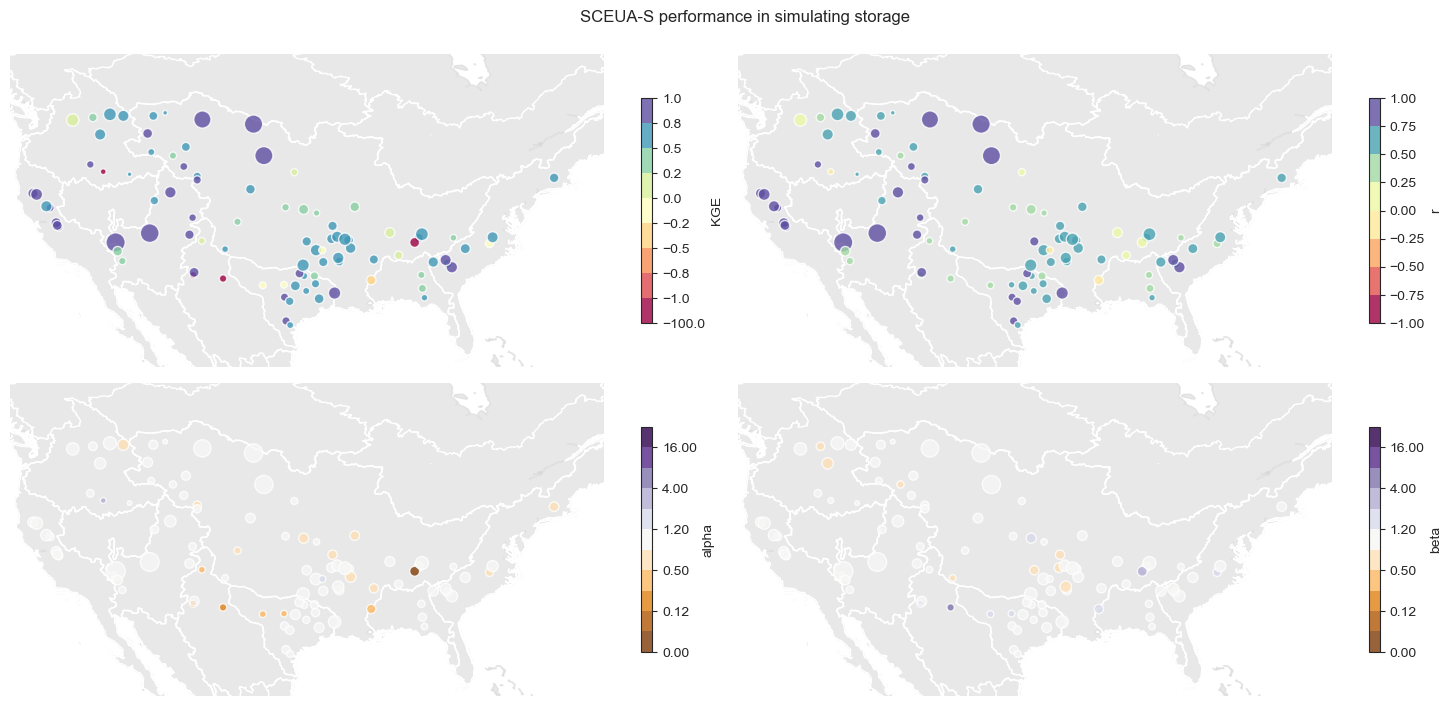

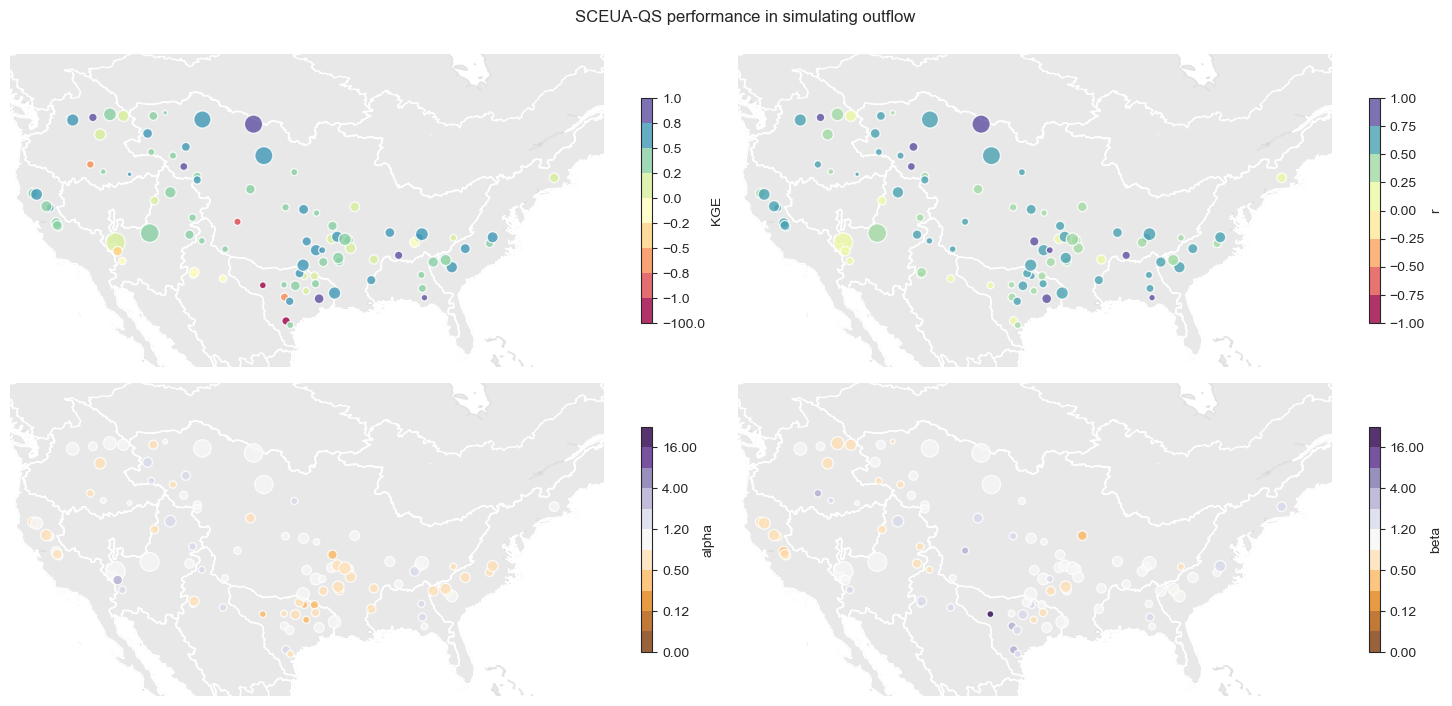

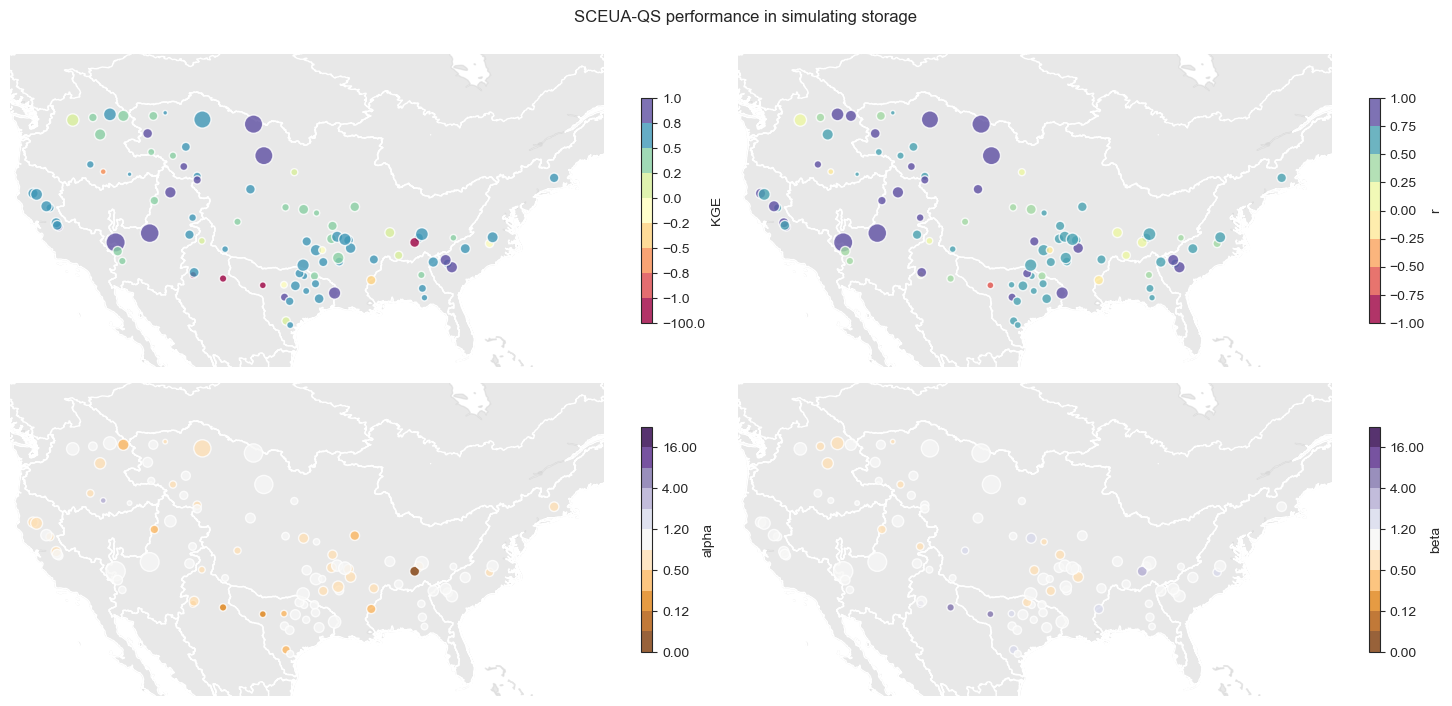

In [141]:
for sampling in list(performance):
    for var in performance.variable.data:

        fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 7), tight_layout=True, subplot_kw={'projection': proj})

        for i, metric in enumerate(['KGE', 'r', 'alpha', 'beta']):

            if metric == 'KGE':
                cmap, norm = create_cmap('Spectral', [-100, -1, -.75, -.5, -.25 ,0, .25, .5, .75, 1])
            elif metric in ['alpha', 'beta']:
                cmap, norm = create_cmap('PuOr', [1e-6, 1/16, 1/8, 1/4, 1/2, 1/1.2, 1.2, 2, 4, 8, 16, 1e6])
            elif metric == 'r':
                cmap, norm = create_cmap('Spectral', [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1])

            # background map
            ax = axes[int(i / 2), i % 2]
            ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
            catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
            ax.set_extent(extent)
            ax.axis('off')

            # scatter plot
            sct = ax.scatter(reservoirs.geometry.x,
                             reservoirs.geometry.y,
                             c=performance[sampling].sel(variable=var, metric=metric, ResID=reservoirs.index).data,
                             cmap=cmap, norm=norm, edgecolor='w', lw=1, 
                              s=reservoirs.CAP**.5, alpha=.8)
            # # setup: color bar, title...
            cbar = plt.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
            cbar.set_label(metric, rotation=90)

        fig.text(.5, 1.0, f'{sampling} performance in simulating {var}', ha='center', va='bottom', fontsize=12);
        
        plt.savefig(path_out / f'maps_performance_{sampling}_{var}.jpg', dpi=300, bbox_inches='tight')

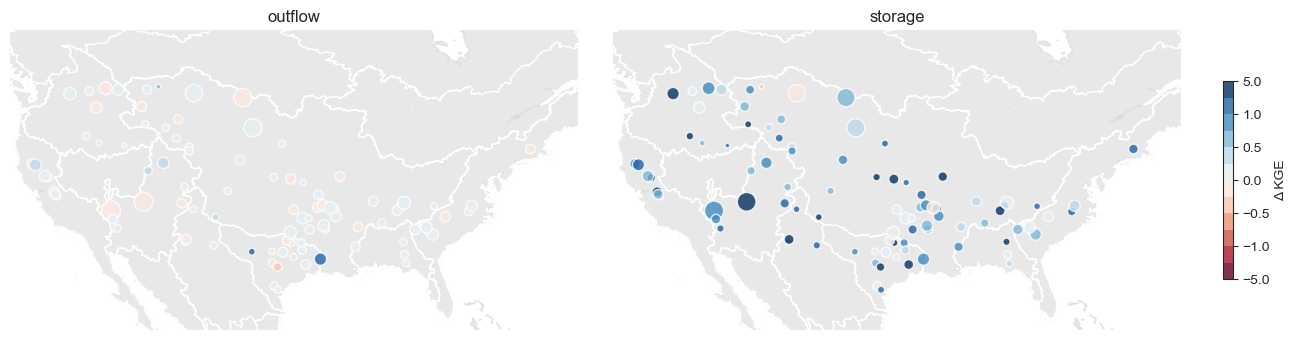

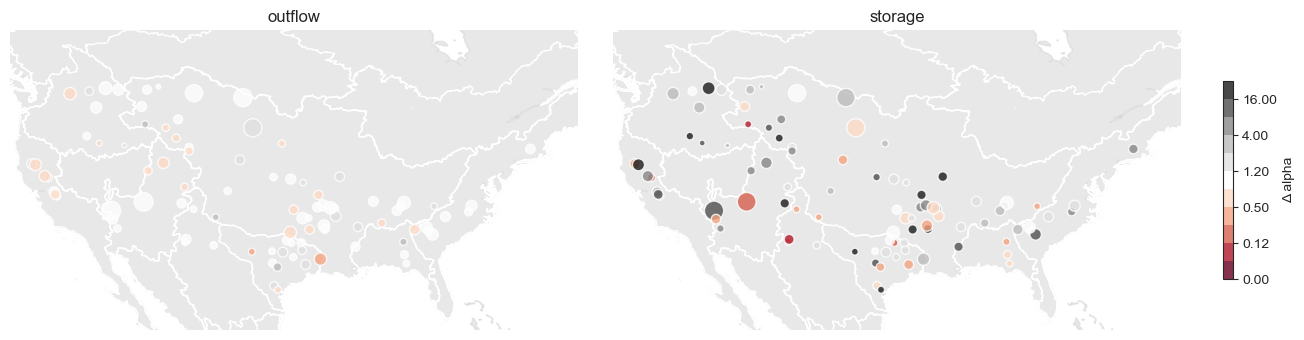

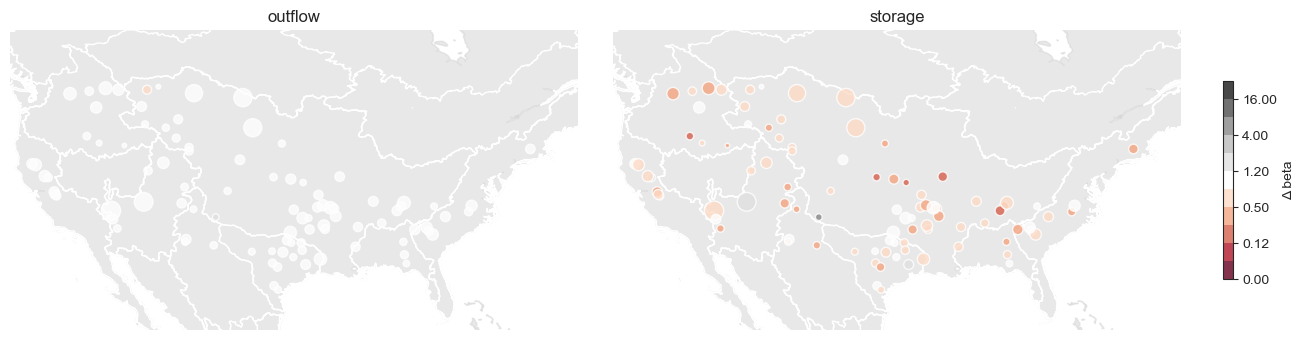

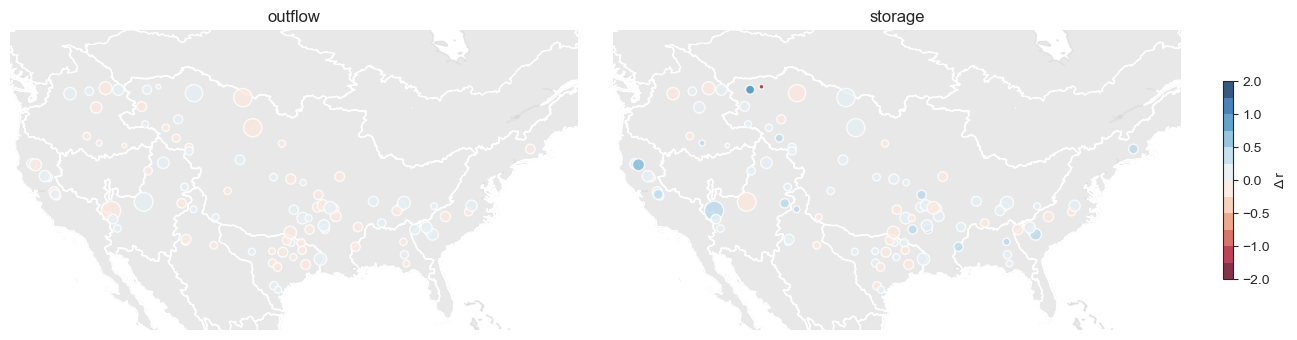

In [117]:
sampling = 'SCEUA-QS'

for metric in performance.metric.data:

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 3.5), tight_layout=True, subplot_kw={'projection': proj})

    for ax, var in zip(axes, performance.variable.data):

        benchmark = performance['GloFAS'].sel(variable=var).to_pandas()
        calibration = performance[sampling].sel(variable=var).to_pandas()

        if metric in ['KGE', 'r']:
            change = calibration - benchmark
        elif metric in ['alpha', 'beta']:
            change = calibration / benchmark

        if metric == 'KGE':
            cmap, norm = create_cmap('RdBu', [-5, -2, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 2, 5])
        elif metric in ['alpha', 'beta']:
            cmap, norm = create_cmap('RdGy', [1e-6, 1/16, 1/8, 1/4, 1/2, 1/1.2, 1.2, 2, 4, 8, 16, 1e6])
        elif metric == 'r':
            cmap, norm = create_cmap('RdBu', [-2, -1.5, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 1.5 , 2])

        # background map
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
        catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
        ax.set_extent(extent)
        ax.set_title(var)
        ax.axis('off')

        # scatter plot
        sct = ax.scatter(reservoirs.geometry.x,
                         reservoirs.geometry.y,
                         c=change[metric],
                         cmap=cmap, norm=norm, edgecolor='w', lw=1, 
                          s=reservoirs.CAP**.5, alpha=.8)
    # # setup: color bar, title...
    cbar = fig.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
    cbar.set_label(f'Δ {metric}', rotation=90)
    
    plt.savefig(path_out / f'maps_improvement_{sampling}_{metric}.jpg', dpi=300, bbox_inches='tight')

### Optimized parameters

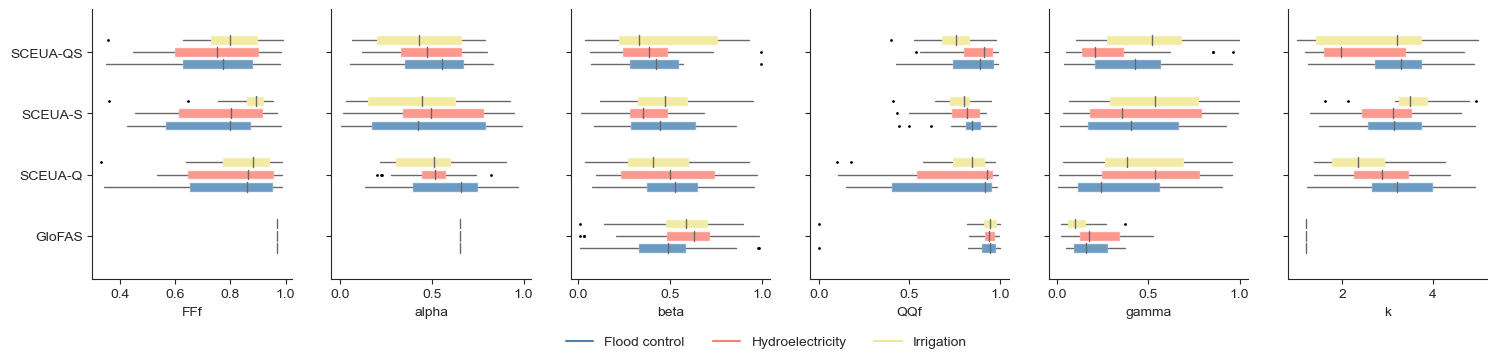

In [142]:
mask_KGE = reservoirs.loc[KGE_bivar['SCEUA-QS'] > 0].index

color_mapping = {'Flood control': 'steelblue', 'Hydroelectricity': 'salmon', 'Irrigation': 'khaki'}
w = .2

n_pars = len(parameters.parameter)
fig, axes = plt.subplots(ncols=n_pars, figsize=(3 * n_pars, 3.5), sharey=True)
for ax, par in zip(axes, parameters.parameter.data):
    yticks, yticklabels = [], []
    for i, (sampling, da) in enumerate(parameters.items(), start=1):
        # print(i, sampling)
        yticks.append(i)
        yticklabels.append(sampling)
        for j, use in enumerate(['Flood control', 'Hydroelectricity', 'Irrigation']):
            ResIDs = list(set(mask_KGE).intersection(reservoirs[reservoirs.MAIN_USE == use].index))
            box_color = color_mapping[use]
            ax.boxplot(da.sel(parameter=par, ResID=ResIDs).data,
                       positions=[i + (j - 1) * w],
                       widths=w * .8,
                       vert=False,
                       patch_artist=True,
                       boxprops=dict(facecolor=box_color, edgecolor=None, alpha=.8),
                       medianprops={'color': 'dimgray'},
                       whiskerprops=dict(color='dimgray', linestyle='-'),
                       showcaps=False,
                       flierprops=dict(marker='.', markersize=2)
                      )
            ax.plot([], color=box_color, label=use)
    ax.set(xlabel=par)
    ax.spines[['right', 'top']].set_visible(False)
    #if ax == axes[0]:
    #    ax.set_ylabel('sampling')
ax.set_yticks(ticks=yticks, labels=yticklabels)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], frameon=False, loc=8, ncol=3, bbox_to_anchor=[.333, -.125, .333, .05]);

plt.savefig(path_out / 'optimized_parameters.jpg', dpi=300, bbox_inches='tight')

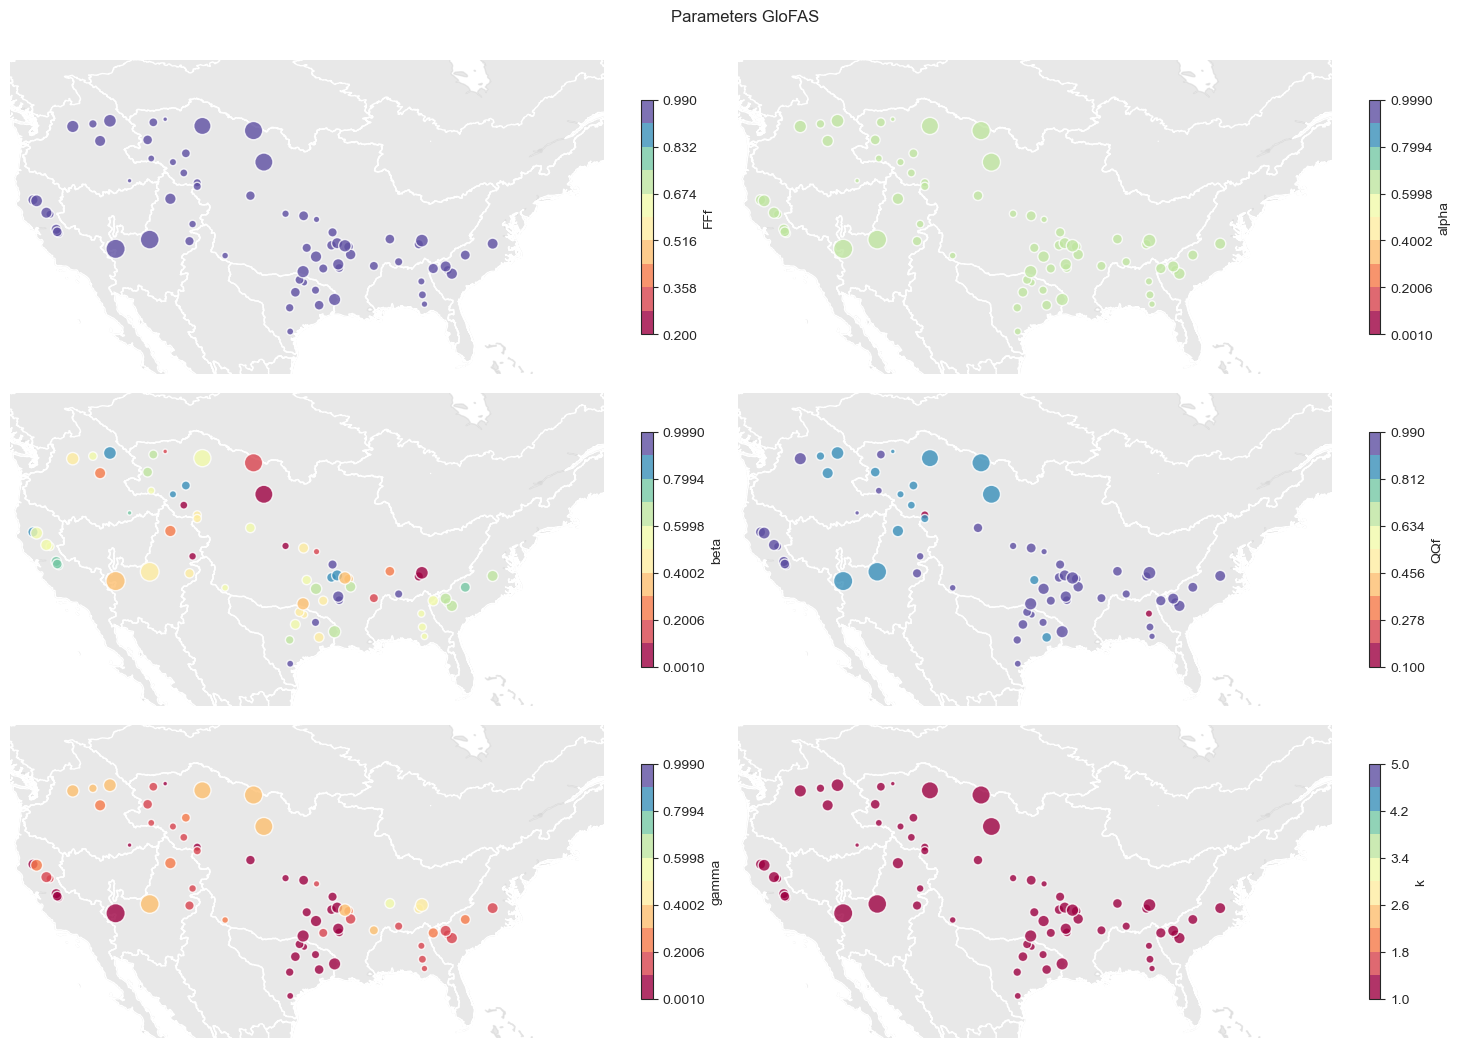

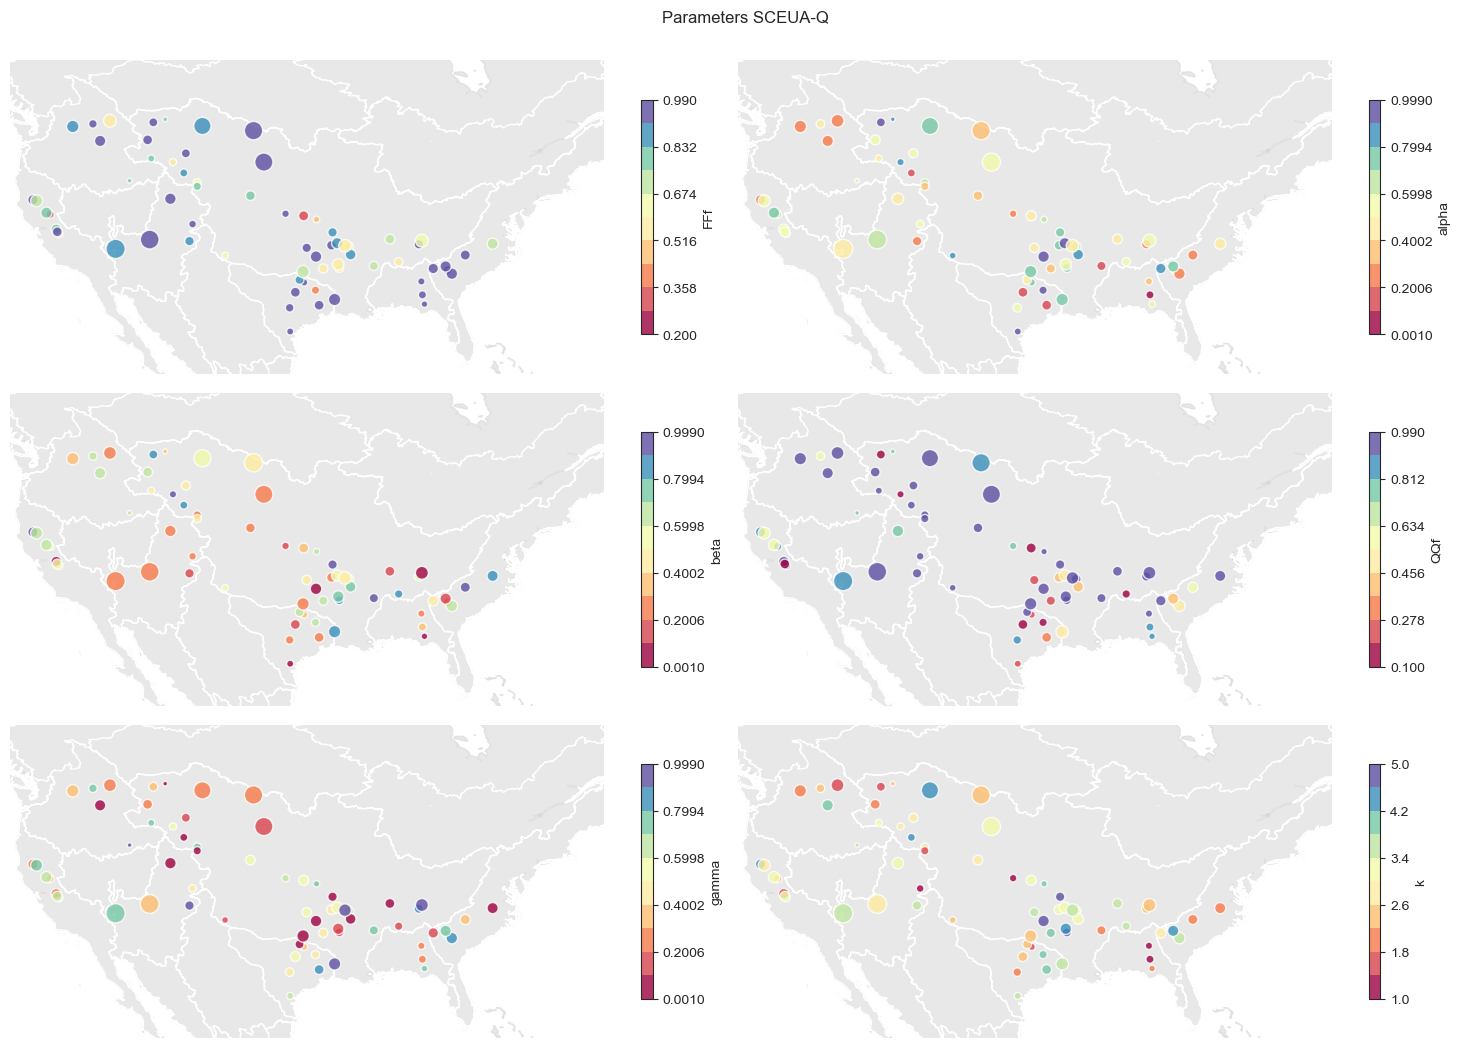

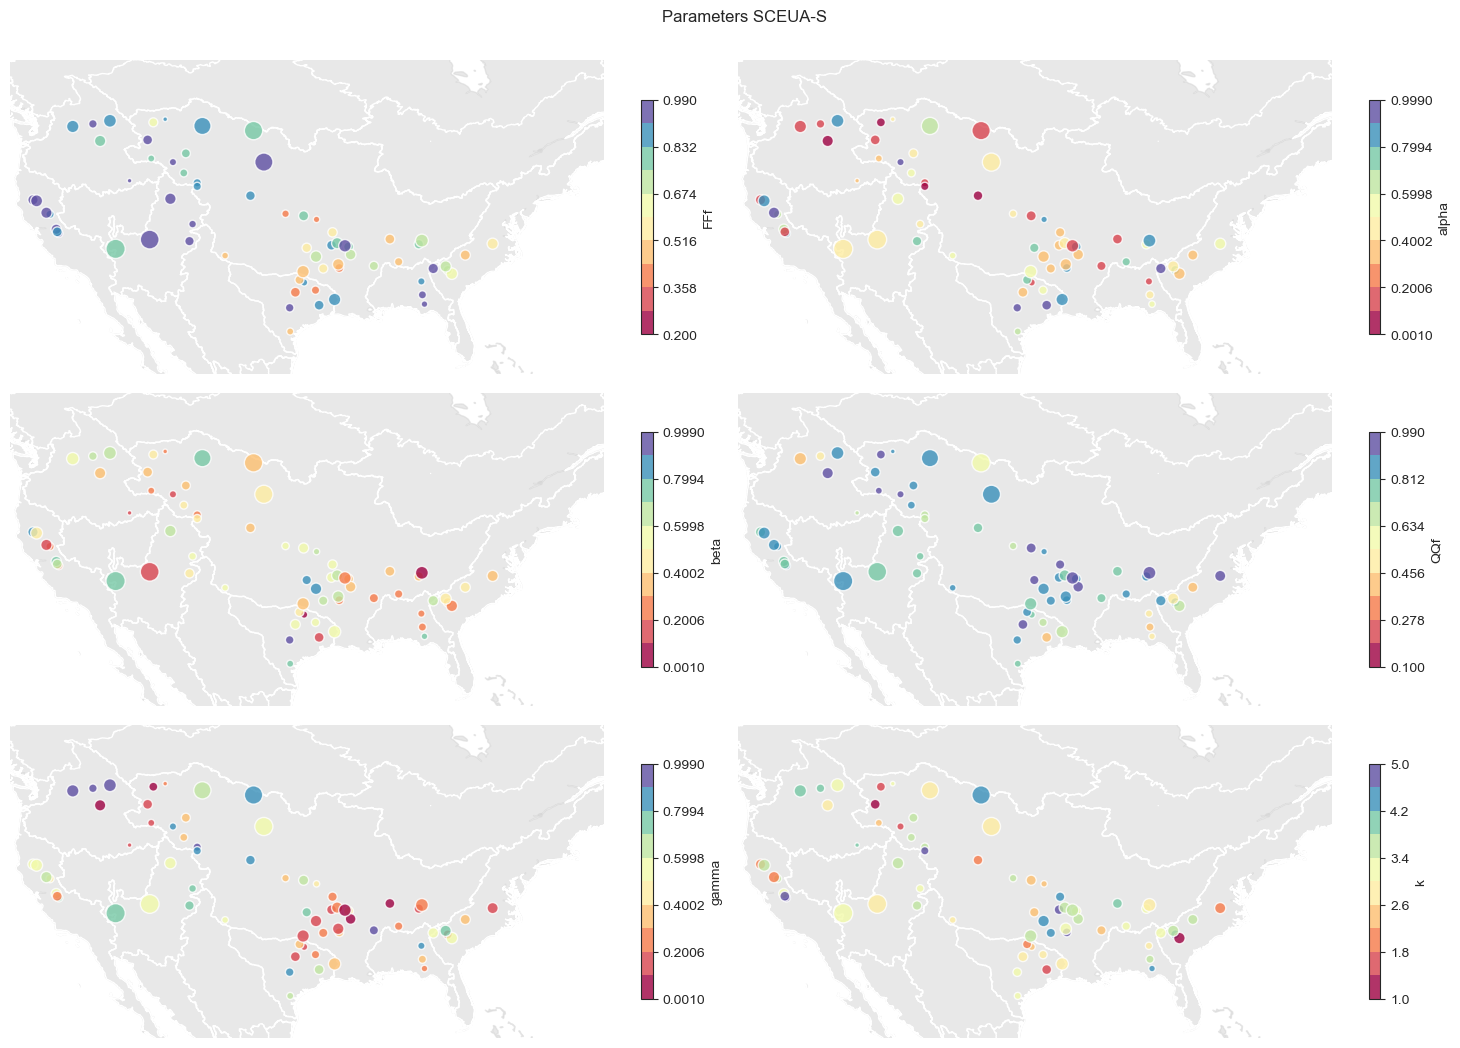

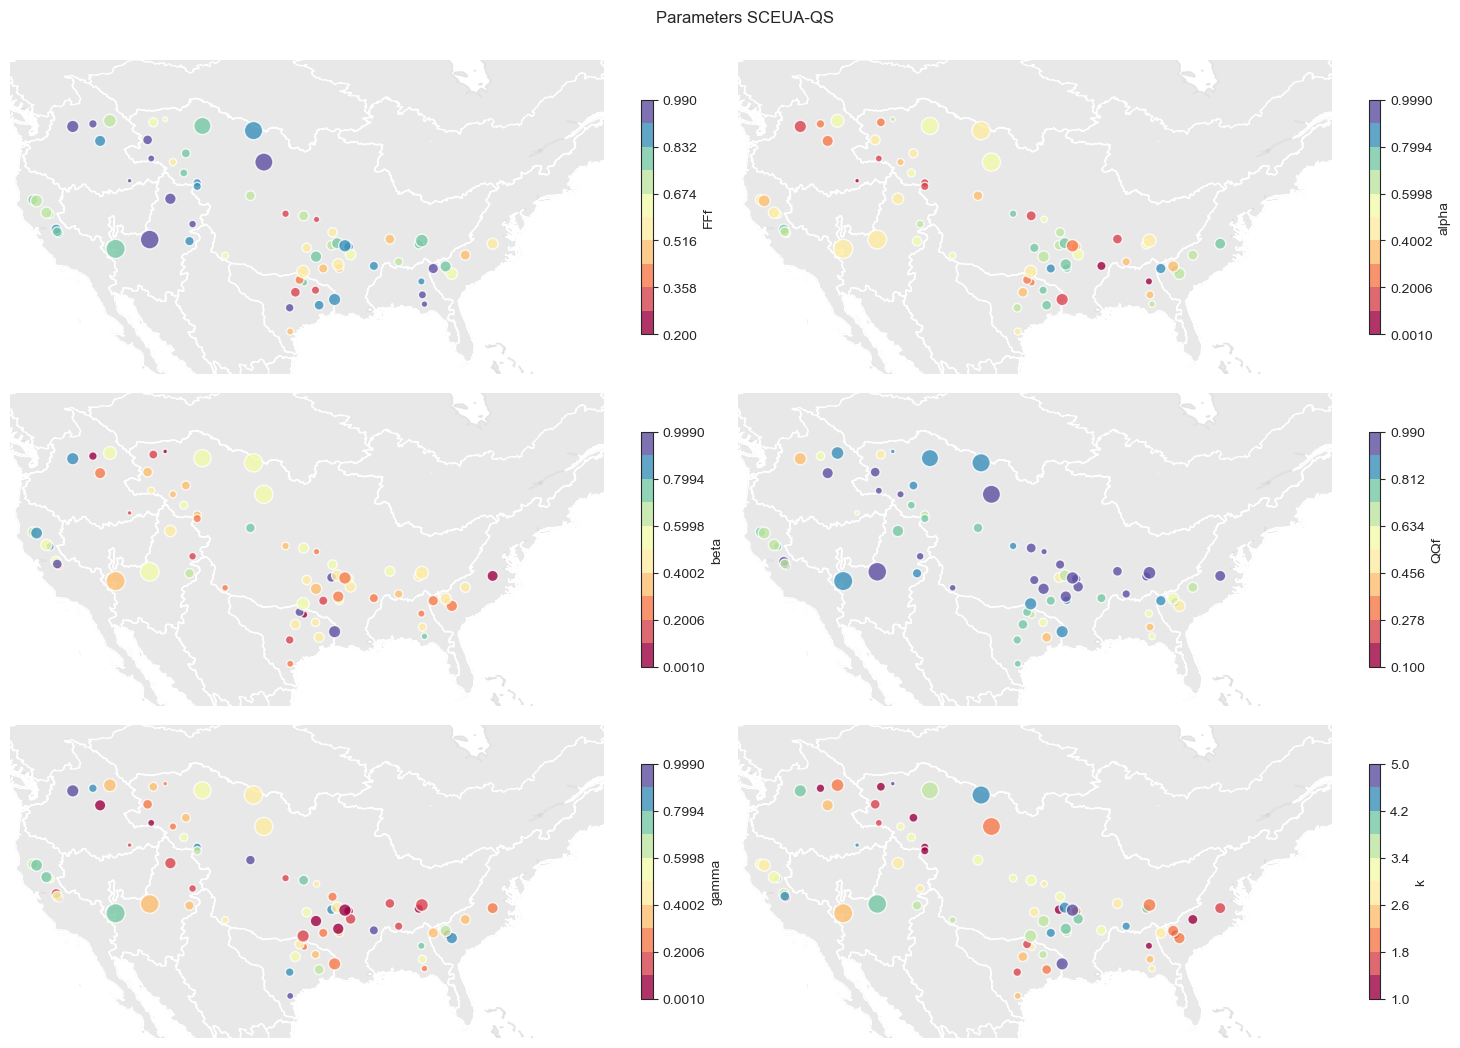

In [140]:
sampling = 'SCEUA-QS'
for sampling, da in parameters.items():

    nrows = 3
    fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(15, 3.5 * nrows), tight_layout=True, subplot_kw={'projection': proj})

    for i, par in enumerate(parameters.parameter.data):

        # fig, ax = plt.subplots(figsize=(20, 5), subplot_kw=dict(projection=proj))
        ax = axes[int(i / 2), i % 2]
        ax.set_extent(extent)
        catchment_pol.plot(facecolor='none', edgecolor='white', ax=ax)
        ax.axis('off')

        # background map
        ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='lightgray'), alpha=.5, zorder=0)
        # scatter plot
        cmap, norm = create_cmap('Spectral', np.linspace(*par_space[par], 11))
        sct = ax.scatter(reservoirs.loc[mask_KGE].geometry.x,
                         reservoirs.loc[mask_KGE].geometry.y,
                         c=parameters[sampling].sel(parameter=par, ResID=mask_KGE).data,
                         s=reservoirs.loc[mask_KGE].CAP**.5, 
                         cmap=cmap, norm=norm, edgecolor='w', lw=1,  alpha=.8)
        # # setup: color bar, title...
        cbar = plt.colorbar(sct, ax=ax, shrink=.66)#, orientation='horizontal')
        cbar.set_label(par, rotation=90)

    fig.text(.5, 1.0, f'Parameters {sampling}', ha='center', va='bottom', fontsize=12);
    plt.savefig(path_out / f'maps_parameters_{sampling}.jpg', dpi=300, bbox_inches='tight')

Create a map of the difference in the parameters between GloFAS a SCEUA-QS.